**Load the libraries**


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import string
from collections import Counter

Load the dataset

In [2]:
df=pd.read_csv('/content/dataset/combined_emotion.csv')

EDA

In [3]:
print(df.head())

                                            sentence emotion
0      i just feel really helpless and heavy hearted    fear
1  ive enjoyed being able to slouch about relax a...     sad
2  i gave up my internship with the dmrg and am f...    fear
3                         i dont know i feel so lost     sad
4  i am a kindergarten teacher and i am thoroughl...    fear


View some sample data

In [4]:
print(df.sample(10))

                                                 sentence  emotion
257186  i havent given in for a day week month so now ...     love
238223  i gave him a faint nod to thank him for lettin...      sad
162280  i feel like things like that happen all the ti...     fear
279400  i wouldnt feel so depressed about the united s...      sad
292666  i still feel as though something sweet and won...      joy
42553   i am how good i feel hes probably a little dis...     fear
119147  i feel that it is important to be up front wit...      joy
406406         i began to feel strange like i might faint  suprise
233078  i feel you have to apply a generous amount to ...     love
246920  i am feeling really disillusioned with everything      sad


Check the data null values and the column with row

In [5]:
print(f"Dataframe size: {df.shape}")
print(df.isnull().sum())

Dataframe size: (422746, 2)
sentence    0
emotion     0
dtype: int64


Show the datasets in bar chart

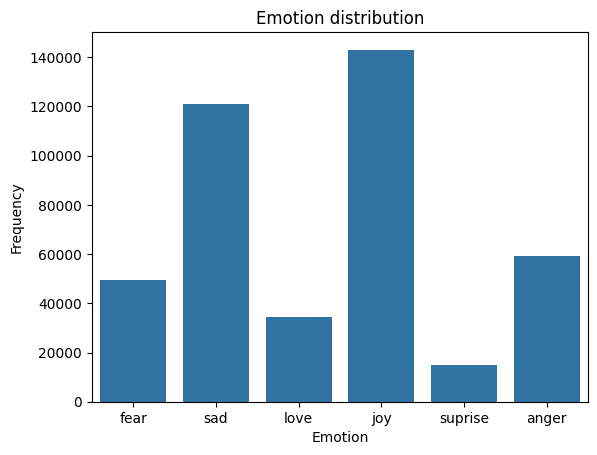

In [6]:
sns.countplot(data=df, x='emotion')
plt.title('Emotion distribution')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.show()

Show the datasets via value per feature

In [7]:
class_counts = df['emotion'].value_counts()
print(class_counts)

emotion
joy        143067
sad        121187
anger       59317
fear        49649
love        34554
suprise     14972
Name: count, dtype: int64


Some useful insights on the sentences of the dataset

We are creating a column with sentences length

In [8]:
# Add column with sentence length (including spaces)
df['sentence_length'] = df['sentence'].apply(len)

Show the length of the sentences via bar chart

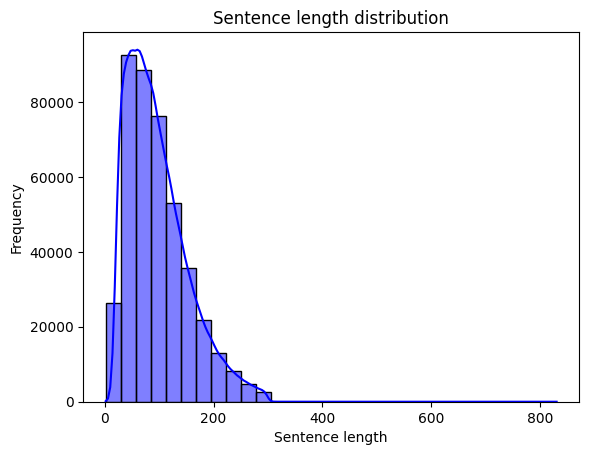

In [9]:
# Show distribution of sentence length
sns.histplot(df['sentence_length'], bins=30, kde=True, color='blue')
plt.title('Sentence length distribution')
plt.xlabel('Sentence length')
plt.ylabel('Frequency')
plt.show()



Show the neccessary information on sentences

In [10]:
# Show sentence length statistics
print(df['sentence_length'].describe())

count    422746.000000
mean         97.033980
std          56.198156
min           2.000000
25%          54.000000
50%          86.000000
75%         128.000000
max         830.000000
Name: sentence_length, dtype: float64


From the sentences column we can consider the max length sentences is 830 character and small length is 2

We can see the sentence_length is also coming with value

In [11]:
print(df.head())

                                            sentence emotion  sentence_length
0      i just feel really helpless and heavy hearted    fear               45
1  ive enjoyed being able to slouch about relax a...     sad              234
2  i gave up my internship with the dmrg and am f...    fear               63
3                         i dont know i feel so lost     sad               26
4  i am a kindergarten teacher and i am thoroughl...    fear              222


Showing each emotion per average sentences length

In [12]:
avg_length_by_emotion = df.groupby('emotion')['sentence_length'].mean().reset_index()

Showing via bar chart

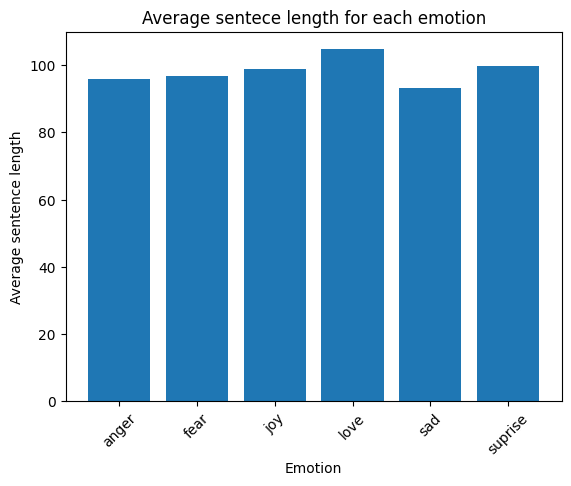

In [13]:
plt.bar(avg_length_by_emotion['emotion'], avg_length_by_emotion['sentence_length'])
plt.xlabel("Emotion")
plt.ylabel("Average sentence length")
plt.title("Average sentece length for each emotion")
plt.xticks(rotation=45)
plt.show()

Download the nltk libraries

In [14]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

Text Preprocessing techniques

In [15]:
# Define preprocessing function
def preprocess_text(text):
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Join back into a cleaned sentence
    return ' '.join(tokens)

In [16]:
# Preprocess and reconstruct sentences
df['processed_tokens'] = df['sentence'].apply(preprocess_text)
df['cleaned_sentence'] = df['processed_tokens'].apply(lambda tokens: ' '.join(tokens))


In [17]:
# Count most frequent words across all processed tokens
all_words = [word for tokens in df['processed_tokens'] for word in tokens]
word_freq = Counter(all_words)


Show the top 20 most popular words from the dataset

In [20]:
max_Words = 20 # number of most popular words

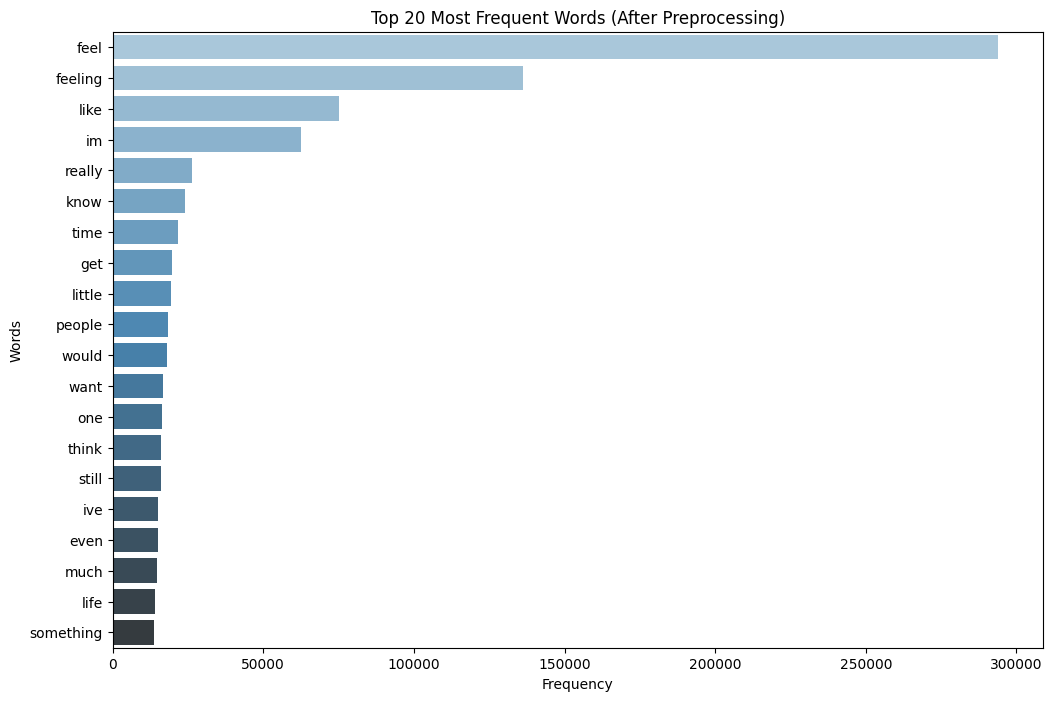

In [24]:
common_words = word_freq.most_common(max_Words)
# Plotting the most common words
x = [word[1] for word in common_words]  # Frequencies
y_words = [word[0] for word in common_words]  # Words
plt.figure(figsize=(12, 8))
sns.barplot(x=x, y=y_words, hue=y_words, palette='Blues_d', legend=False)
plt.title(f'Top {max_Words} Most Frequent Words (After Preprocessing)')
plt.xlabel("Frequency")
plt.ylabel("Words")
plt.show()


Show the top 10 words from each emotions

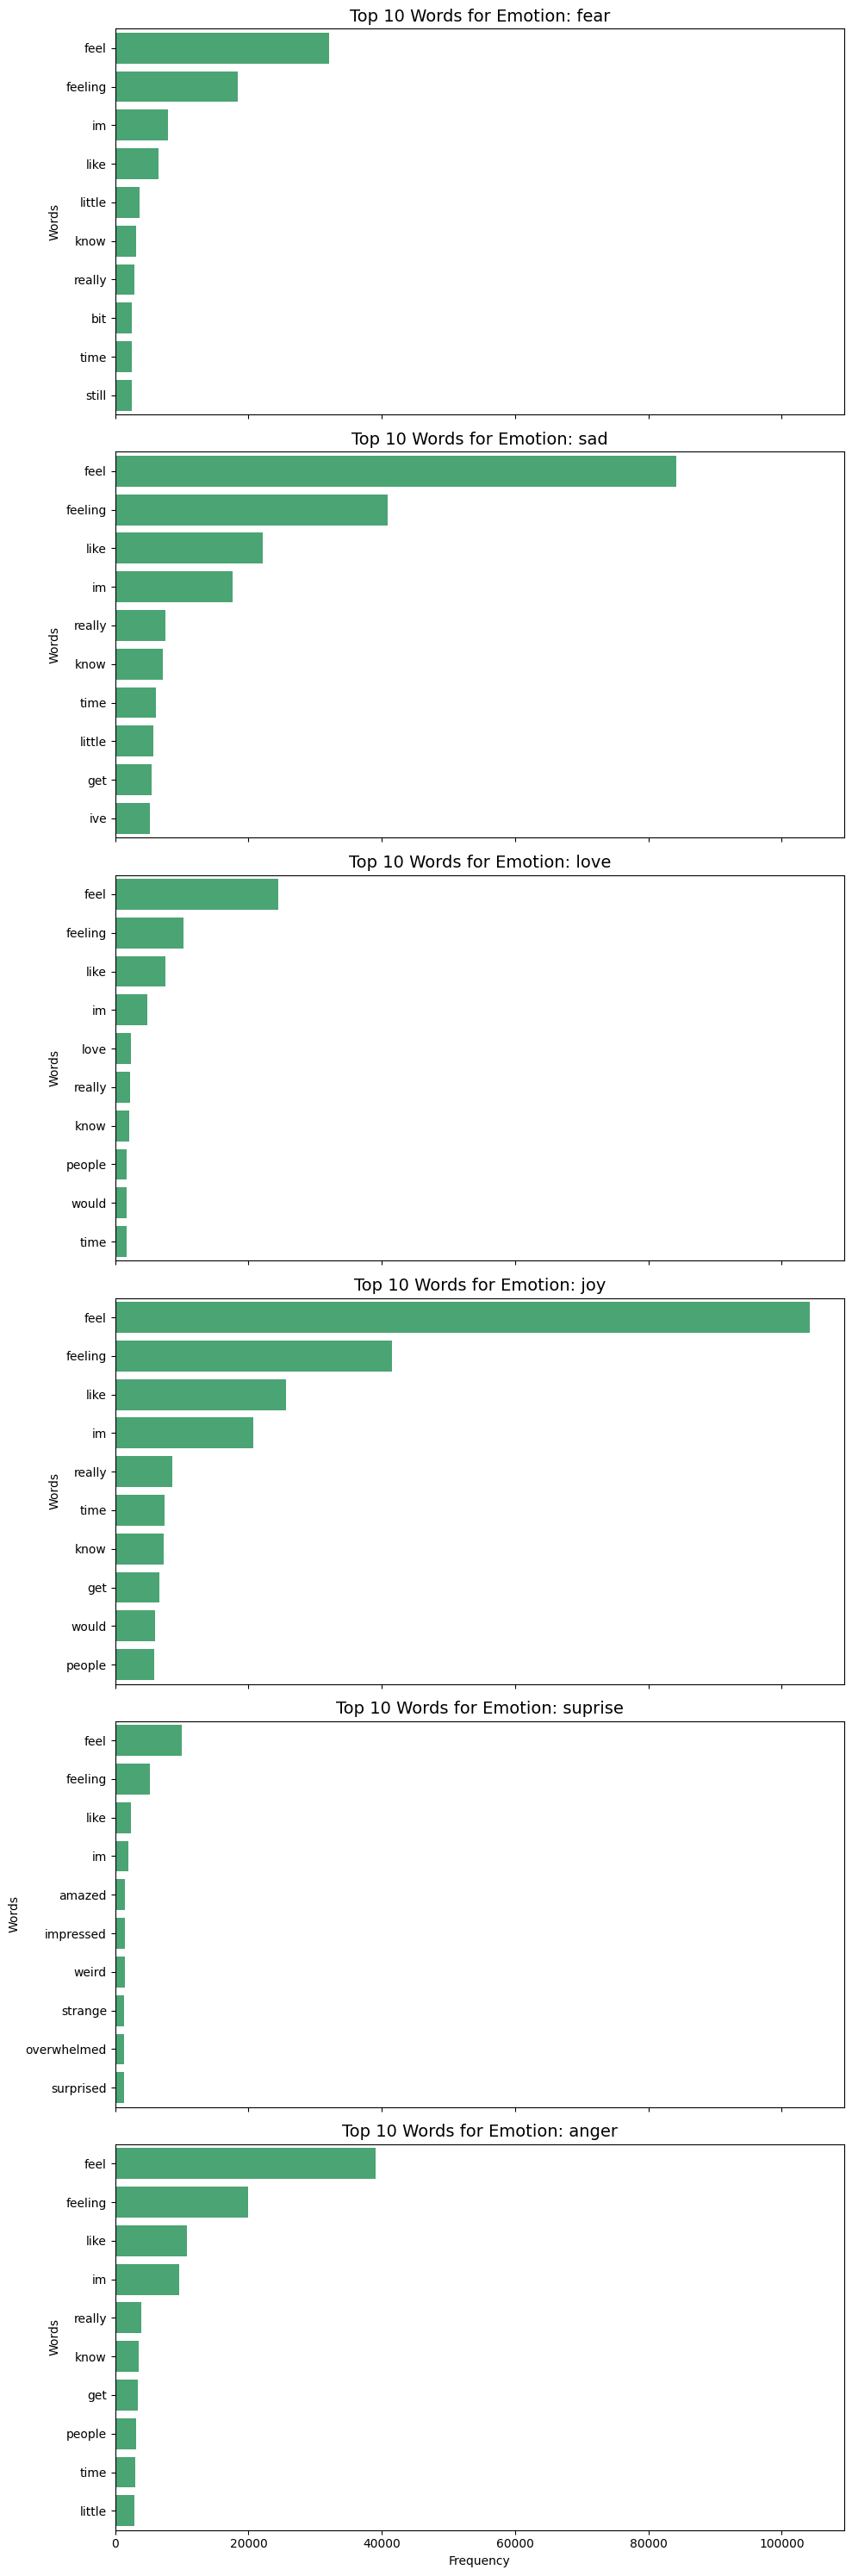

In [25]:
# Calculate word frequencies per emotion using preprocessed tokens
emotion_word_freq = {}

for emotion in df['emotion'].unique():
    # Get all tokens from that emotion group
    emotion_tokens = df[df['emotion'] == emotion]['processed_tokens'].explode().dropna()

    if not emotion_tokens.empty:
        word_counts = Counter(emotion_tokens)
        emotion_word_freq[emotion] = word_counts.most_common(10)
    else:
        emotion_word_freq[emotion] = []

# Remove empty entries
emotion_word_freq = {k: v for k, v in emotion_word_freq.items() if v}

# Plotting
num_emotions = len(emotion_word_freq)
fig, axes = plt.subplots(nrows=num_emotions, figsize=(10, 5 * num_emotions), sharex=True)

for i, (emotion, freq) in enumerate(emotion_word_freq.items()):
    words, counts = zip(*freq)
    ax = axes[i] if num_emotions > 1 else axes
    sns.barplot(x=list(counts), y=list(words), color='mediumseagreen', ax=ax)
    ax.set_title(f'Top 10 Words for Emotion: {emotion}', fontsize=14)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Words')

plt.tight_layout()
plt.show()


show the datasets

In [26]:
print(df.head())

                                            sentence emotion  sentence_length  \
0      i just feel really helpless and heavy hearted    fear               45   
1  ive enjoyed being able to slouch about relax a...     sad              234   
2  i gave up my internship with the dmrg and am f...    fear               63   
3                         i dont know i feel so lost     sad               26   
4  i am a kindergarten teacher and i am thoroughl...    fear              222   

                                    processed_tokens  \
0           [feel, really, helpless, heavy, hearted]   
1  [ive, enjoyed, able, slouch, relax, unwind, fr...   
2      [gave, internship, dmrg, feeling, distraught]   
3                           [dont, know, feel, lost]   
4  [kindergarten, teacher, thoroughly, weary, job...   

                                    cleaned_sentence  
0                 feel really helpless heavy hearted  
1  ive enjoyed able slouch relax unwind frankly n...  
2          

Split the datasets into train and test datasets

In [27]:
print(df.isnull().sum())


sentence            0
emotion             0
sentence_length     0
processed_tokens    0
cleaned_sentence    0
dtype: int64


In [28]:
df = df.dropna(subset=["sentence", "emotion"])


In [29]:


X = df['cleaned_sentence']  # cleaned text
y = df['emotion']           # target labels

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



In [ ]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

emotion
joy        0.338422
sad        0.286665
anger      0.140315
fear       0.117444
love       0.081737
suprise    0.035417
Name: proportion, dtype: float64
emotion
joy        0.338427
sad        0.286671
anger      0.140308
fear       0.117445
love       0.081739
suprise    0.035411
Name: proportion, dtype: float64


Do the vectorization

In [31]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

Apply class weight logistic Regression

🔹 Balanced  Logistic Regression
Accuracy: 91.58249556475458

Classification report:
               precision    recall  f1-score   support

       anger       0.90      0.94      0.92     11863
        fear       0.88      0.87      0.88      9930
         joy       0.98      0.90      0.93     28614
        love       0.74      0.97      0.84      6911
         sad       0.98      0.93      0.95     24238
     suprise       0.69      0.94      0.79      2994

    accuracy                           0.92     84550
   macro avg       0.86      0.92      0.89     84550
weighted avg       0.93      0.92      0.92     84550

Confusion Matrix:
 [[11108   405   122    37   166    25]
 [  274  8643    56    29   130   798]
 [  210   128 25633  2114   194   335]
 [   16     7   161  6689    20    18]
 [  717   506   225   138 22538   114]
 [    2   129    26    11     4  2822]]


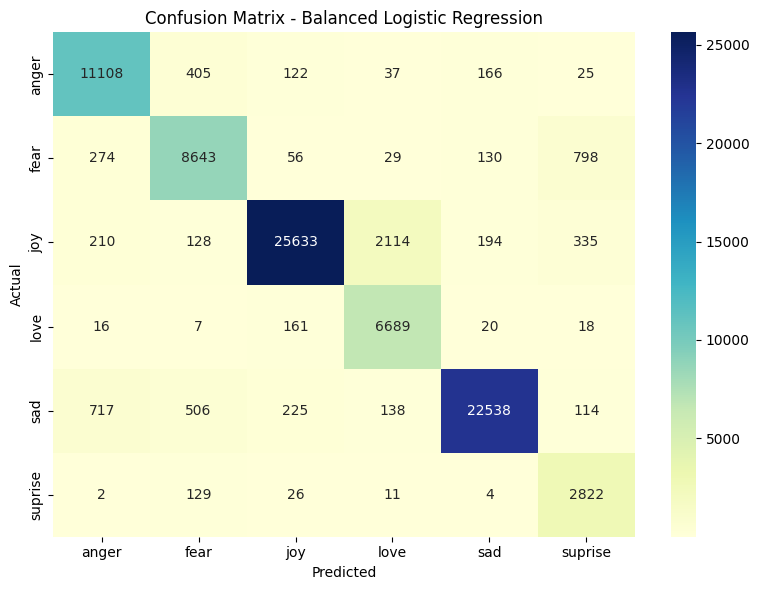

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Train model
model = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=200)
model.fit(X_train_tfidf, y_train)

# Predict
y_pred = model.predict(X_test_tfidf)

# Evaluation
print("🔹 Balanced  Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred)*100)
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Confusion Matrix (text)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Confusion Matrix Chart
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Balanced Logistic Regression")
plt.tight_layout()
plt.show()


Logistic Regression

In [67]:
model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

Accuracy: 91.33293908929627

Classification Report:
               precision    recall  f1-score   support

       anger       0.92      0.91      0.92     11863
        fear       0.87      0.88      0.87      9930
         joy       0.92      0.95      0.93     28614
        love       0.83      0.78      0.80      6911
         sad       0.95      0.95      0.95     24238
     suprise       0.80      0.70      0.75      2994

    accuracy                           0.91     84550
   macro avg       0.88      0.86      0.87     84550
weighted avg       0.91      0.91      0.91     84550



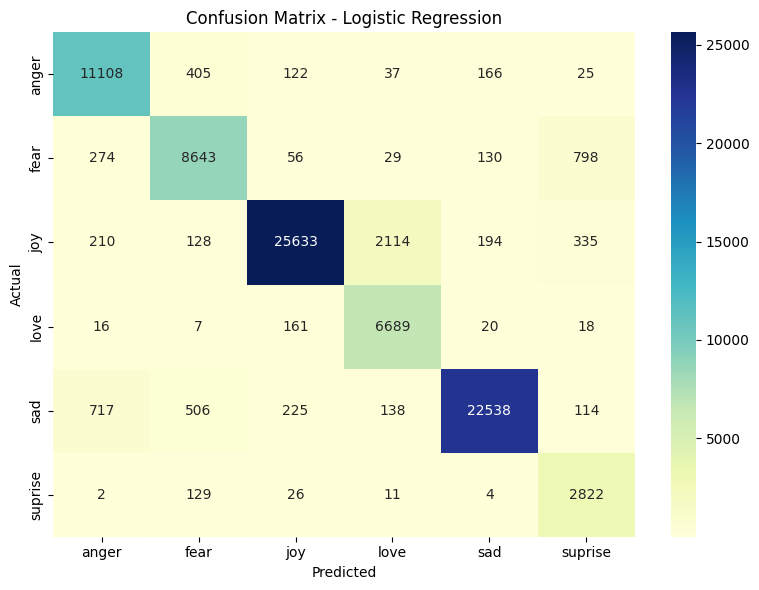

In [68]:
y_pred2 = model_lr.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred2)*100)
print("\nClassification Report:\n", classification_report(y_test, y_pred2))
# Confusion Matrix Chart
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Logistic Regression")
plt.tight_layout()
plt.show()


Random Forest

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [37]:
rf_model = RandomForestClassifier(n_estimators=100)
rf_model.fit(X_train_tfidf, y_train)

RandomForestClassifier()

🔹 Random Forest
Accuracy: 86.57007687758723
Classification Report:
               precision    recall  f1-score   support

       anger       0.86      0.90      0.88     11863
        fear       0.79      0.83      0.81      9930
         joy       0.91      0.88      0.89     28614
        love       0.69      0.71      0.70      6911
         sad       0.92      0.92      0.92     24238
     suprise       0.66      0.64      0.65      2994

    accuracy                           0.87     84550
   macro avg       0.81      0.81      0.81     84550
weighted avg       0.87      0.87      0.87     84550



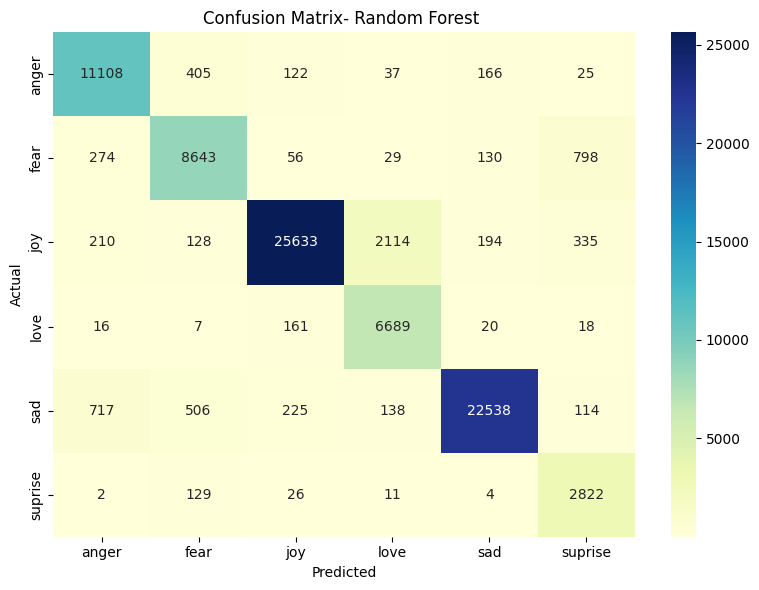

In [46]:
y_pred_rf = rf_model.predict(X_test_tfidf)

# Evaluate
print("🔹 Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf)*100)
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix Chart
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix- Random Forest ")
plt.tight_layout()
plt.show()

Linear SVM

In [61]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Wrap LinearSVC to enable probability estimation
base_svm = LinearSVC(dual=False, class_weight='balanced')
svm_model = CalibratedClassifierCV(base_svm)  # ⬅️ Enables predict_proba
svm_model.fit(X_train_tfidf, y_train)





CalibratedClassifierCV(estimator=LinearSVC(class_weight='balanced', dual=False))

🔹 Linear SVM
Accuracy: 91.14370195150798
Classification Report:
               precision    recall  f1-score   support

       anger       0.91      0.92      0.92     11863
        fear       0.86      0.87      0.87      9930
         joy       0.93      0.93      0.93     28614
        love       0.79      0.84      0.81      6911
         sad       0.96      0.95      0.95     24238
     suprise       0.74      0.72      0.73      2994

    accuracy                           0.91     84550
   macro avg       0.87      0.87      0.87     84550
weighted avg       0.91      0.91      0.91     84550



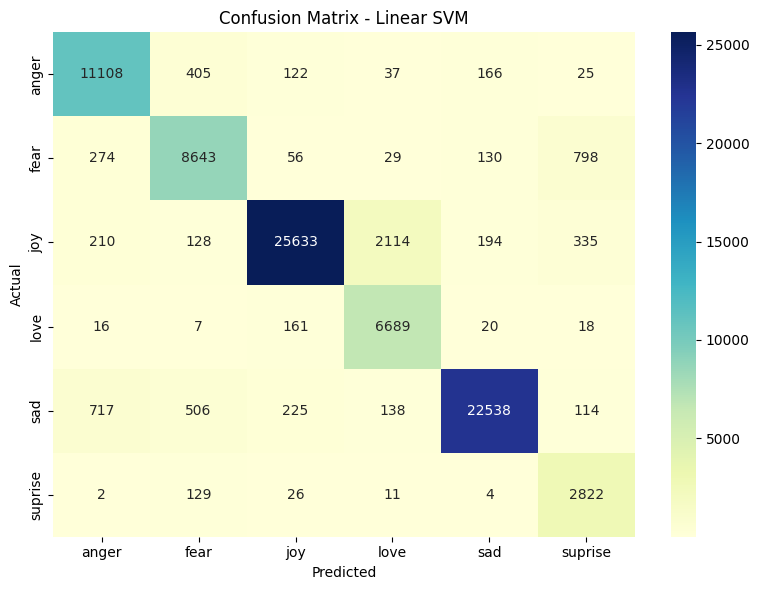

In [62]:
# Predict
y_pred_svm = svm_model.predict(X_test_tfidf)

# Evaluate
print("🔹 Linear SVM")
print("Accuracy:", accuracy_score(y_test, y_pred_svm)*100)
print("Classification Report:\n", classification_report(y_test, y_pred_svm))
# Confusion Matrix Chart
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu',
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Linear SVM")
plt.tight_layout()
plt.show()

Test on sample input

📝 Input: I am feeling extremely happy and excited today!
➡️ Predicted Emotion: joy


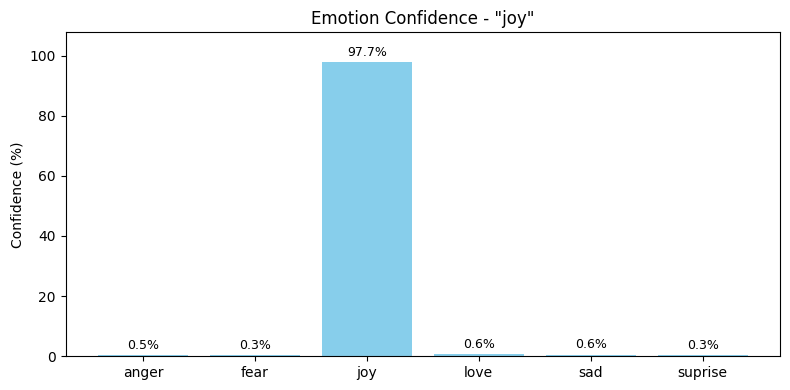

In [75]:
import matplotlib.pyplot as plt

# Sample input sentence
sample_text = "I am feeling extremely happy and excited today!"

# Vectorize and predict
sample_vector = tfidf_vectorizer.transform([sample_text])
predicted_emotion = svm_model.predict(sample_vector)[0]
probabilities = svm_model.predict_proba(sample_vector)[0]
labels = svm_model.classes_

# 👉 Display predicted emotion
print(f"📝 Input: {sample_text}")
print(f"➡️ Predicted Emotion: {predicted_emotion}")

# 👉 Bar chart with adjusted Y-limit and label positions
plt.figure(figsize=(8, 4))
bars = plt.bar(labels, probabilities * 100, color='skyblue')

plt.title(f"Emotion Confidence - \"{predicted_emotion}\"")
plt.ylabel("Confidence (%)")
plt.ylim(0, max(probabilities * 100) + 10)  # ⬅️ Add space above tallest bar

# Add value labels slightly above bars
for bar, prob in zip(bars, probabilities):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2,
             height + 1,                      # ⬅️ Move label above bar
             f"{prob * 100:.1f}%",
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()









📝 Input: I am so sad and heartbroken.
➡️ Predicted Emotion: sad



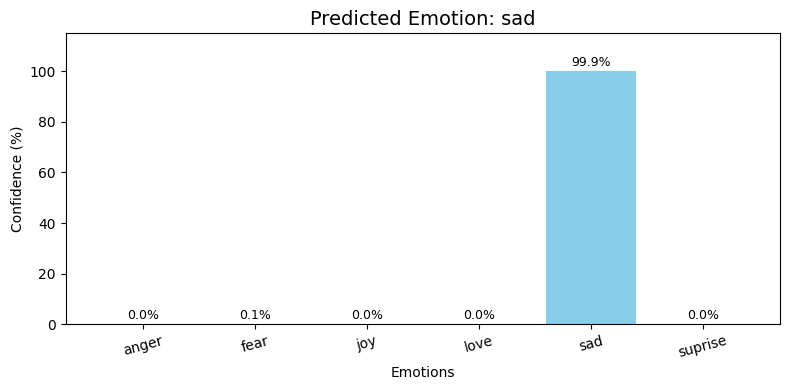

📝 Input: Wow! This is amazing and exciting!
➡️ Predicted Emotion: suprise



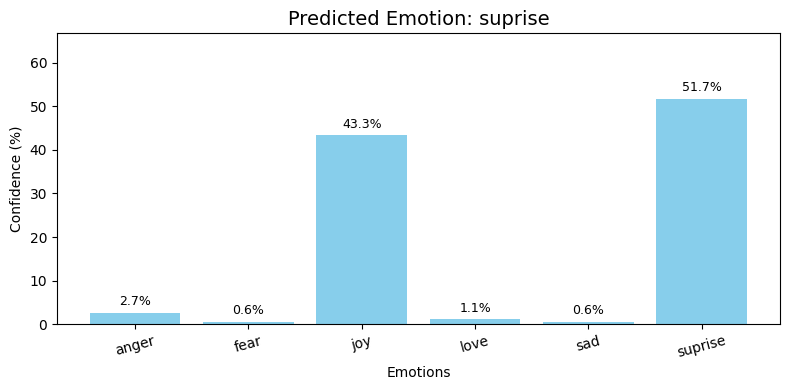

📝 Input: I am nervous about my exam results.
➡️ Predicted Emotion: fear



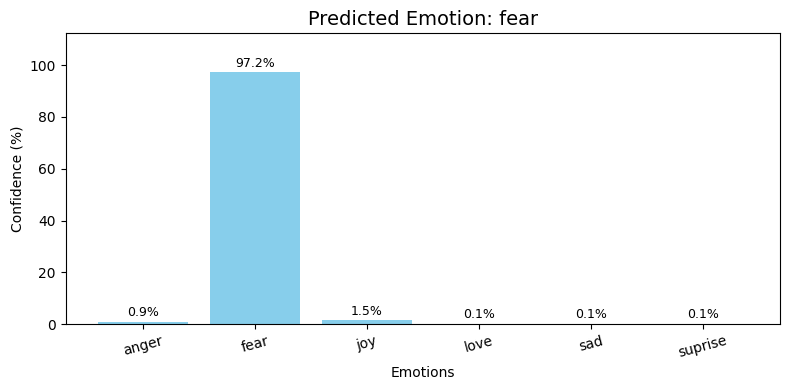

📝 Input: I hate when people are rude.
➡️ Predicted Emotion: anger



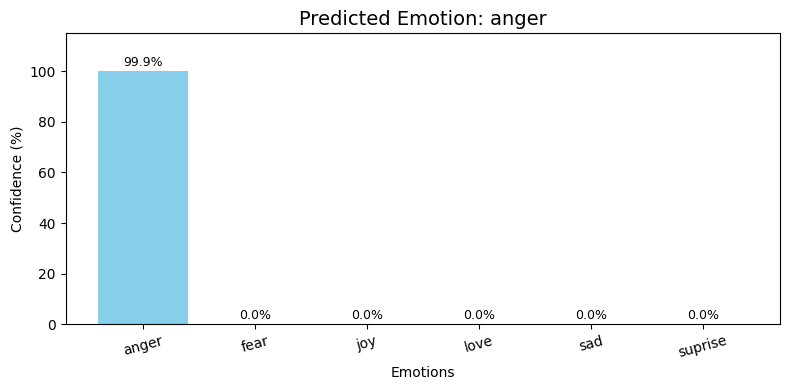

📝 Input: Feeling peaceful and calm today.
➡️ Predicted Emotion: joy



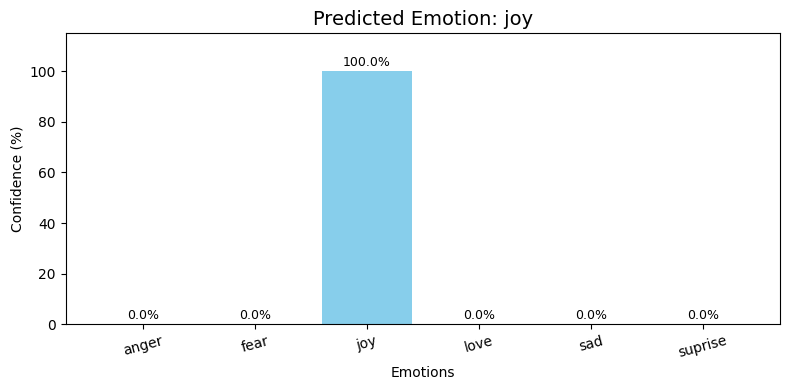

In [77]:
import matplotlib.pyplot as plt

# Sample input sentences
sample_texts = [
    "I am so sad and heartbroken.",
    "Wow! This is amazing and exciting!",
    "I am nervous about my exam results.",
    "I hate when people are rude.",
    "Feeling peaceful and calm today."
]

# Get predictions and probabilities
sample_vectors = tfidf_vectorizer.transform(sample_texts)
probs = svm_model.predict_proba(sample_vectors)  # Requires CalibratedClassifierCV
emotions = svm_model.classes_
predicted_emotions = svm_model.predict(sample_vectors)

# Plot emotion probabilities for each sentence
for i, text in enumerate(sample_texts):
    confidence_scores = probs[i] * 100
    predicted_emotion = predicted_emotions[i]

    # 👉 Print input and predicted emotion
    print(f"📝 Input: {text}")
    print(f"➡️ Predicted Emotion: {predicted_emotion}\n")

    # 👉 Plot bar chart
    plt.figure(figsize=(8, 4))
    bars = plt.bar(emotions, confidence_scores, color='skyblue')
    plt.ylim(0, max(confidence_scores) + 15)

    plt.title(f"Predicted Emotion: {predicted_emotion}", fontsize=14)
    plt.xlabel("Emotions")
    plt.ylabel("Confidence (%)")

    # Add confidence % on top of each bar
    for bar, score in zip(bars, confidence_scores):
        plt.text(bar.get_x() + bar.get_width()/2,
                 bar.get_height() + 1,
                 f"{score:.1f}%",
                 ha='center', va='bottom', fontsize=9)

    plt.xticks(rotation=15)
    plt.tight_layout()
    plt.show()






Summary

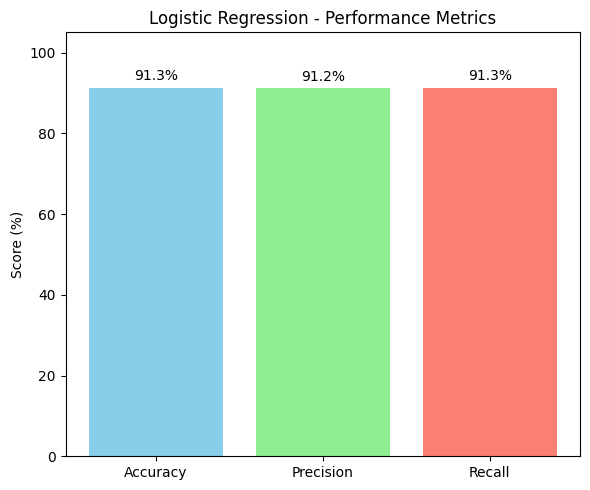

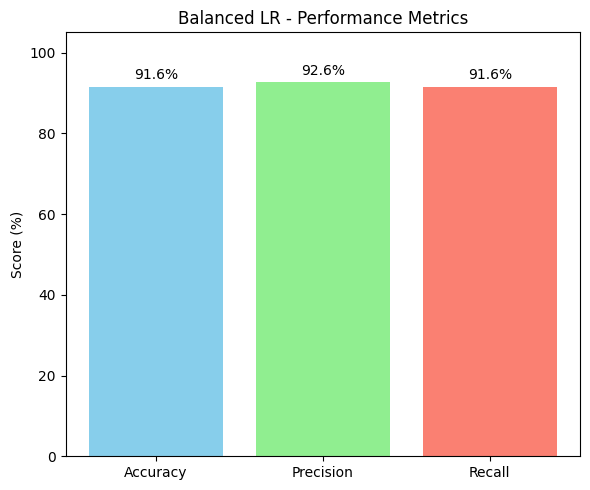

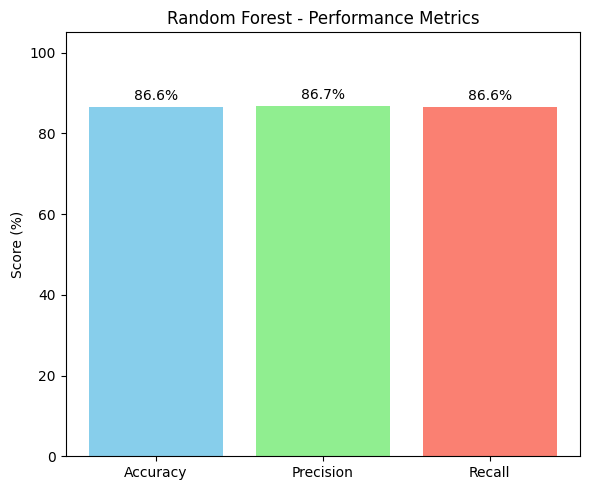

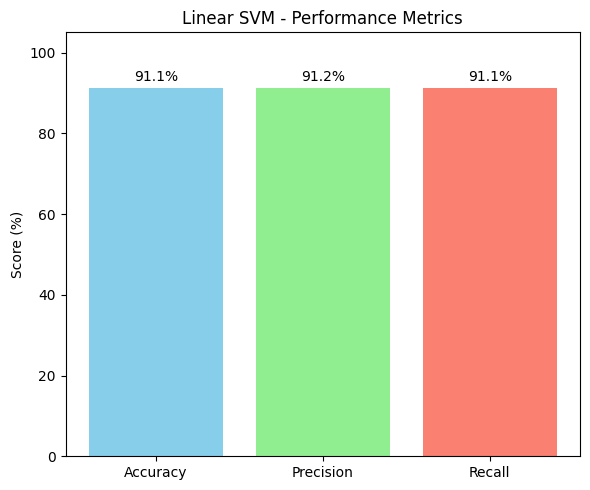

In [69]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Calculate scores for all models
model_scores = {
    "Logistic Regression": {
        "Accuracy": accuracy_score(y_test, y_pred2) * 100,
        "Precision": precision_score(y_test, y_pred2, average='weighted', zero_division=0) * 100,
        "Recall": recall_score(y_test, y_pred2, average='weighted', zero_division=0) * 100
    },
    "Balanced LR": {
        "Accuracy": accuracy_score(y_test, y_pred) * 100,
        "Precision": precision_score(y_test, y_pred, average='weighted', zero_division=0) * 100,
        "Recall": recall_score(y_test, y_pred, average='weighted', zero_division=0) * 100
    },
    "Random Forest": {
        "Accuracy": accuracy_score(y_test, y_pred_rf) * 100,
        "Precision": precision_score(y_test, y_pred_rf, average='weighted', zero_division=0) * 100,
        "Recall": recall_score(y_test, y_pred_rf, average='weighted', zero_division=0) * 100
    },
    "Linear SVM": {
        "Accuracy": accuracy_score(y_test, y_pred_svm) * 100,
        "Precision": precision_score(y_test, y_pred_svm, average='weighted', zero_division=0) * 100,
        "Recall": recall_score(y_test, y_pred_svm, average='weighted', zero_division=0) * 100
    }
}

# Plot each model's metrics as a separate bar chart
for model_name, scores in model_scores.items():
    metrics = list(scores.keys())
    values = list(scores.values())

    plt.figure(figsize=(6, 5))
    bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])

    # Add value labels
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"{height:.1f}%",
                 ha='center', va='bottom', fontsize=10)

    plt.ylim(0, 105)
    plt.title(f"{model_name} - Performance Metrics")
    plt.ylabel("Score (%)")
    plt.tight_layout()
    plt.show()


Pickel to dump the model

In [79]:
import pickle

# Save model
with open('svm_model1.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

# Save vectorizer
with open('tfidf_vectorizer1.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
